## 回测优化与进出场信号细节
1. 事件驱动引擎
2. 策略编写案例
3. 回测绩效输出
4. 优化策略参数

1. 事件驱动引擎
    1. 安装vnpy_fxdayu: pip install git+https://github.com/xingetouzi/vnpy_fxdayu.git@release-v1.1.19
    2. 运行逻辑

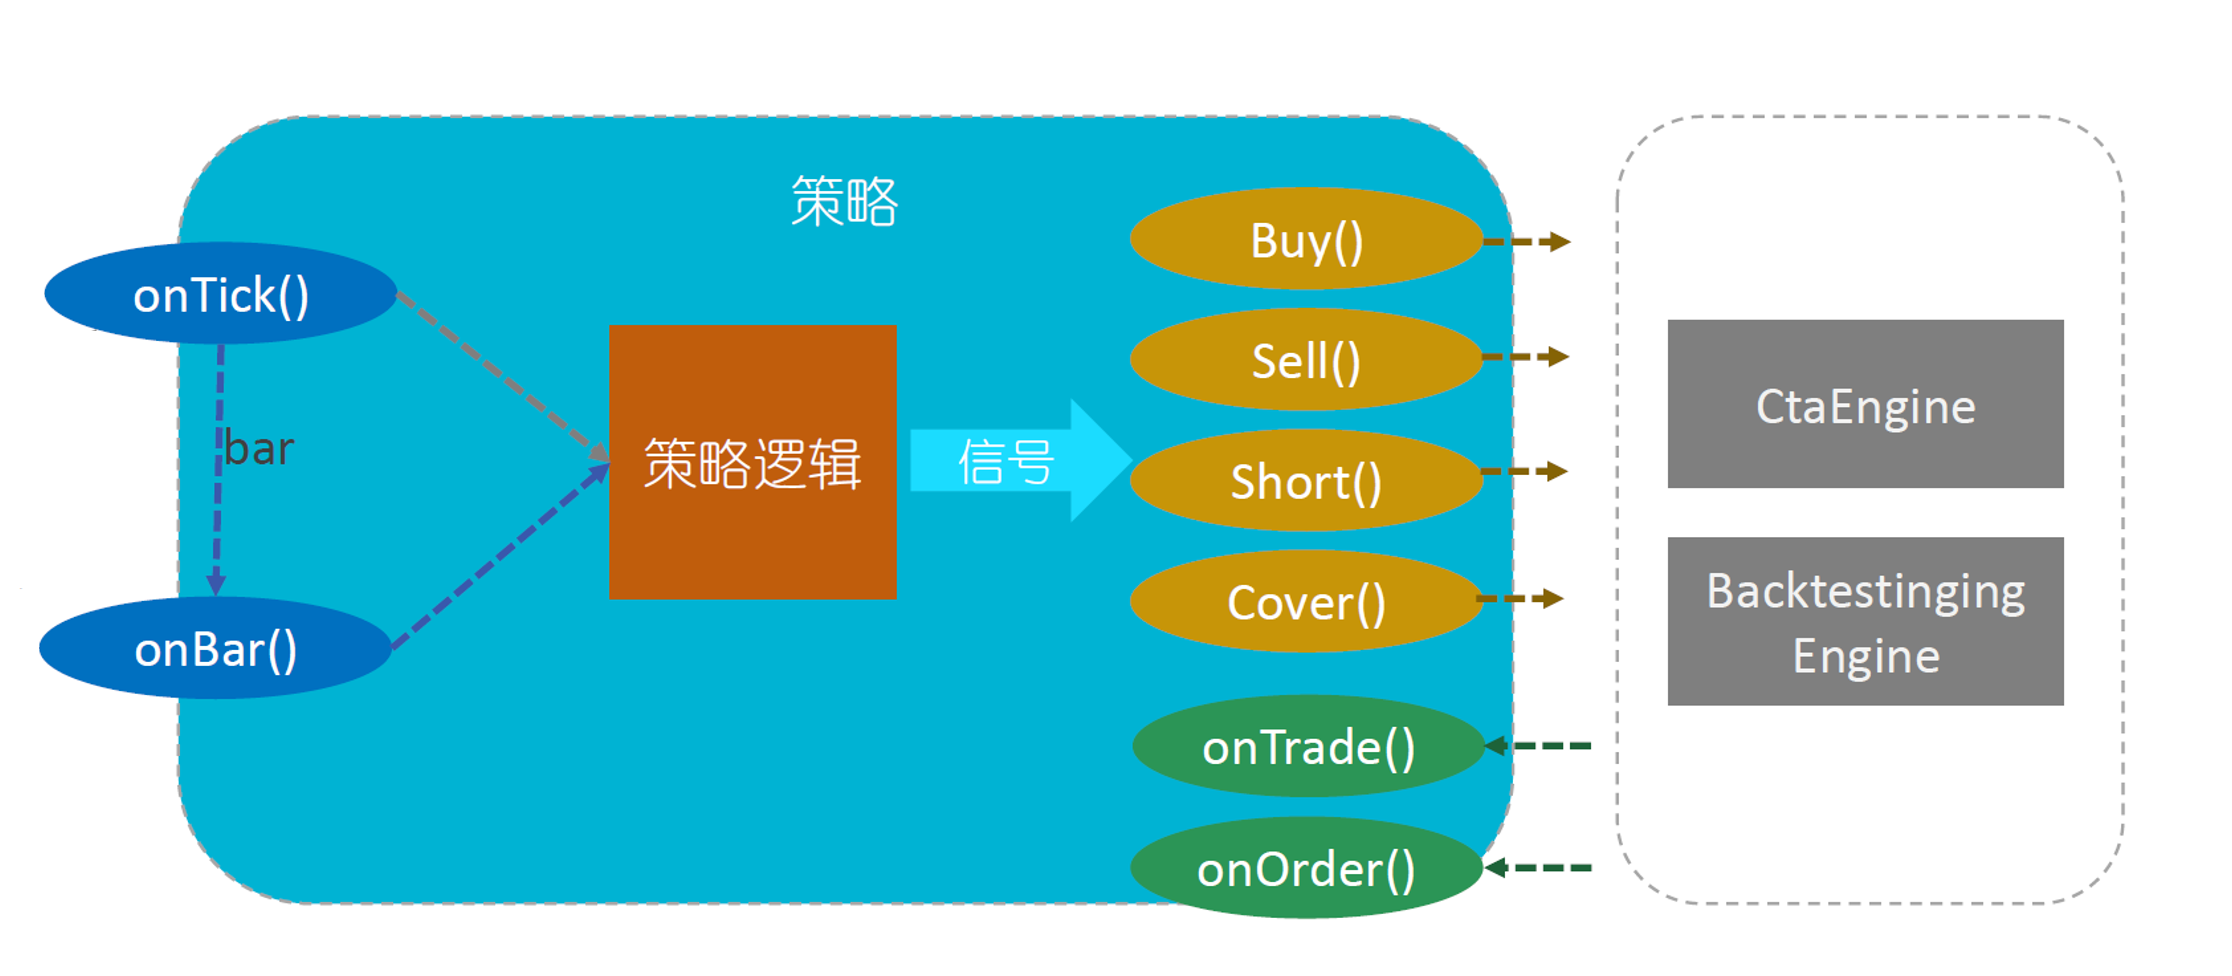

2. 策略编写案例
    1. 冠军策略逻辑
    2. chartLog_画图展示

3. 策略编写步骤
    1. 设置回测模式，日期，品种数据
    2. 设置品种，手续费，滑点
    3. 设置策略参数
    4. 初始化策略
    5. 编写指标信号
    6. 下单执行
    7. 执行回测
    8. 显示回测结果

In [1]:
"""
展示如何执行策略回测。
"""
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

# 创建回测引擎
engine = BacktestingEngine()
# engine.setDB_URI("mongodb://localhost:27017")
engine.setDB_URI("mongodb://192.168.0.104:27017")


# 设置回测模式
engine.setBacktestingMode(engine.BAR_MODE)
engine.setDatabase('VnTrader_1Min_Db')
# 616
# 设置回测日期，initHours 默认值为 0
engine.setStartDate('20170616 11:00:00',initHours=1)   
engine.setEndDate('20190320 23:00:00')

# 设置品种，手续费，滑点
engine.setCapital(10000000)  # 设置起始资金，默认值是1,000,000
contracts = [{
                "symbol":"IF88:CTP",
                "size" : 1, # 每点价值
                "priceTick" : 0.1, # 最小价格变动
                "rate" : 5/10000, # 单边手续费
                "slippage" : 0.5 # 滑价
                },] 

engine.setContracts(contracts)
settingList = [{
                "symbolList": ["IF88:CTP"]
                }]   

In [42]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np
from datetime import datetime

########################################################################
# 策略继承CtaTemplate
class championStrategy(CtaTemplate):
    className = 'championStrategy'
    author = 'ChannelCMT'
    symbolList = ["IF88:CTP"]
    
    barPeriod = 180
    # 策略参数
    cmiPeriod = 40
    cmiMaPeriod = 18
    cmiThreshold = 48
    
    atrPeriod = 60
    smallAtrTime = 2.6
    bigAtrTime = 3
    stopAtrTime = 3
    
    hlMaPeriod = 90
    maPeriod = 70
    
    lowVolThreshold = 0.001

    lot = 1             # 设置手数
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    
    
     # 参数列表
    paramList = [
                 'lot',
                 'cmiPeriod',
                 'cmiMaPeriod',
                 'cmiThreshold',
                 'atrPeriod',
                 'smallAtrTime','bigAtrTime','stopAtrTime',
                 'lowVolThreshold',
                 'hlMaPeriod','maPeriod'
                ]    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.transactionPrice = None # 生成成交价格的字典
        self.trendStatus = None
        self.setArrayManagerSize(self.barPeriod)
        self.chartLog = {
                        'datetime':[],
                        'cmiMa':[],
                        'upperBand':[],
                        'lowerBand':[]
                        }
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on5MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        # 获取数据
        am = self.getArrayManager(symbol, "5m") # 获取历史数组
        
        if not am.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        
        # 判断趋势与盘整状态
        roc = am.close[self.cmiPeriod:]-am.close[:-self.cmiPeriod]
        hl = ta.MAX(am.high, self.cmiPeriod)-ta.MIN(am.low, self.cmiPeriod)
        cmiMa = ta.MA(np.abs(roc[-(self.cmiMaPeriod+10):]/hl[-(self.cmiMaPeriod+10):])*100, self.cmiMaPeriod)
        trendStatus = 1 if cmiMa[-1]>self.cmiThreshold else 0
        
        # 过滤超小波动率
        atr = ta.ATR(am.high, am.low, am.close, self.atrPeriod)
        filterCanTrade = 1 if atr[-1]>am.close[-1]*self.lowVolThreshold else 0
        
        # 区分趋势与盘整计算上下轨
        upperBand, lowerBand = 0, 0
        breakUpperBand, breakLowerBand = 0, 0
        if trendStatus ==0:
            hlcMean = ta.MA((am.high+am.low+am.close)/3, 3)[-1]
            priceDirection = 1 if am.close[-1]> hlcMean else -1
            longMultipler = self.smallAtrTime if priceDirection==1 else self.bigAtrTime
            shortMultipler = self.smallAtrTime if priceDirection==-1 else self.bigAtrTime
            upperBand = am.close[-1]+longMultipler*atr[-1]
            lowerBand = am.close[-1]-shortMultipler*atr[-1]
            breakUpperBand = am.close[-1]>upperBand and am.close[-2]<upperBand
            breakLowerBand = am.close[-1]<lowerBand and am.close[-2]>lowerBand
        elif trendStatus ==1:
            upperBand = ta.MA(am.high, self.hlMaPeriod)[-1]
            lowerBand = ta.MA(am.low, self.hlMaPeriod)[-1]
            breakUpperBand = am.close[-1]>upperBand and am.close[-2]<upperBand
            breakLowerBand = am.close[-1]<lowerBand and am.close[-2]>lowerBand
            
        # 画图记录数据
        self.chartLog['datetime'].append(datetime.strptime(am.datetime[-1], "%Y%m%d %H:%M:%S"))
        self.chartLog['cmiMa'].append(cmiMa[-1])
        self.chartLog['upperBand'].append(upperBand)
        self.chartLog['lowerBand'].append(lowerBand)
        
        # 执行下单方法
        self.entryOrder(bar, breakUpperBand, breakLowerBand, filterCanTrade)
        # 执行出场方法
        self.exitOrder(bar)

    def entryOrder(self, bar, breakUpperBand, breakLowerBand, filterCanTrade):
        symbol = bar.vtSymbol
        if filterCanTrade==1:
            if breakUpperBand and (self.posDict[symbol+'_LONG']==0):
                if  self.posDict[symbol+'_SHORT']==0:
                    self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
                # 如果有空头持仓，则先平空，再做多
                elif self.posDict[symbol+'_SHORT'] > 0:
                    self.cancelAll() # 撤销挂单
                    self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                    self.buy(symbol, bar.close*1.01, self.lot)
            elif breakLowerBand and (self.posDict[symbol+'_SHORT']==0):
                if self.posDict[symbol+'_LONG']==0:
                    self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
                elif self.posDict[symbol+'_LONG'] > 0:
                    self.cancelAll() # 撤销挂单
                    self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                    self.short(symbol, bar.close*0.99, self.lot)

    def exitOrder(self, bar):
        symbol = bar.vtSymbol
        am = self.getArrayManager(symbol, "5m") # 获取历史数组
        if not am.inited:
            return
        
        # 计算均线出场条件
        exitLongTrendSignal = am.low[-1]<ta.MA(am.close, self.maPeriod)[-1]
        exitShortTrendSignal = am.high[-1]>ta.MA(am.close, self.maPeriod)[-1]
        
        # 执行出场条件
        if self.trendStatus==1:
            if exitLongTrendSignal and self.posDict[symbol+'_LONG']>0:
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
            if exitShortTrendSignal and self.posDict[symbol+'_SHORT']>0:
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
        else:
            # 止损出场
            self.onBarStopLoss(bar)
    
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        am = self.getArrayManager(symbol, "5m") # 获取历史数组
        if not am.inited:
            return
        # 计算止损价位
        atr = ta.ATR(am.high, am.low, am.close, self.atrPeriod)
        if self.transactionPrice:
            longStop = self.transactionPrice-self.stopAtrTime*atr[-1]
            shortStop = self.transactionPrice+self.stopAtrTime*atr[-1]
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.low < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.high > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        symbol = order.vtSymbol
        if order.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice = order.price_avg # 记录成交价格
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        pass
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [43]:
from vnpy.trader.utils import htmlplot

engine.setLog(True, "../../log")
engine.initStrategy(championStrategy, settingList[0])

# 开始跑回测
engine.runBacktesting()

初始仓位: {'IF88:CTP_LONG': 0, 'IF88:CTP_SHORT': 0}
2019-04-29 18:48:42.665093	开始回测
2019-04-29 18:48:42.665093	策略初始化
2019-04-29 18:48:42.665093	准备载入数据：时间段:[20170616 10:00:00 , 20170616 11:00:00), 模式: bar
2019-04-29 18:48:42.682075	IF88:CTP： 从本地缓存文件实取60, 最大应取60, 还需从数据库取0
2019-04-29 18:48:42.683075	载入完成, 数据量:60
2019-04-29 18:48:42.683075	初始化预加载数据成功, 数据长度:60
2019-04-29 18:48:42.683075	策略初始化完成
2019-04-29 18:48:42.683075	策略启动完成
2019-04-29 18:48:42.683075	回测时间范围:[20170616 11:00:00,20190320 23:00:00)
2019-04-29 18:48:42.683075	当前回放的时间段:[20170616 11:00:00,20190320 23:00:00)
2019-04-29 18:48:46.497710	准备载入数据：时间段:[20170616 11:00:00 , 20190320 23:00:00), 模式: bar
2019-04-29 18:48:56.301156	IF88:CTP： 从本地缓存文件实取103110, 最大应取925200, 还需从数据库取822090
2019-04-29 18:49:03.329463	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-29 18:49:03.364428	载入完成, 数据量:103110
2019-04-29 18:49:03.447343	准备载入数据：时间段:[20170615 07:51:00 , 20170618 11:01:00), 模式: bar
2019-04-29 18:49:03.493296	IF88:CTP： 从本地缓存文件实取480, 最大应取4510, 还需从数据库取4030
2019-04-2

2019-04-29 18:49:15.105244	计算回测结果
2019-04-29 18:49:15.118230	交割单已生成
2019-04-29 18:49:15.118230	------------------------------
2019-04-29 18:49:15.118230	第一笔交易：	2017-06-23 09:40:00
2019-04-29 18:49:15.118230	最后一笔交易：	2019-03-20 11:05:00
2019-04-29 18:49:15.118230	总交易次数：	81
2019-04-29 18:49:15.118230	总盈亏：	1,896.35
2019-04-29 18:49:15.118230	最大回撤: 	-184.09
2019-04-29 18:49:15.118230	平均每笔盈利：	23.41
2019-04-29 18:49:15.118230	平均每笔滑点：	1.0
2019-04-29 18:49:15.118230	平均每笔佣金：	3.65
2019-04-29 18:49:15.118230	胜率		27.16%
2019-04-29 18:49:15.118230	盈利交易平均值	150.08
2019-04-29 18:49:15.118230	亏损交易平均值	-23.82
2019-04-29 18:49:15.118230	盈亏比：	6.3
2019-04-29 18:49:15.592745	策略回测统计图已保存


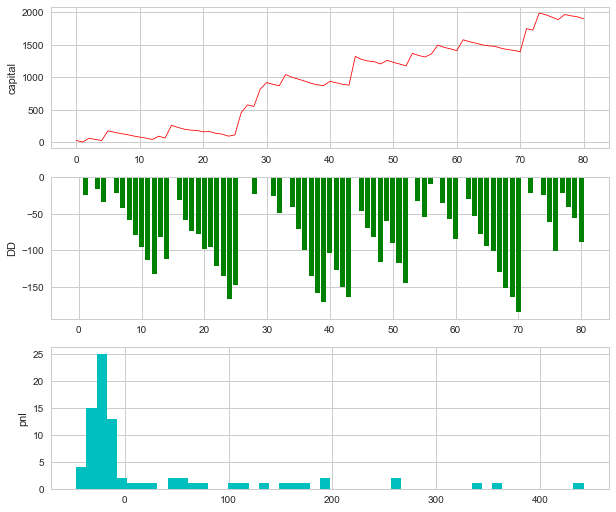

In [44]:
# 显示回测的每张订单绩效
engine.showBacktestingResult()

2019-04-29 18:49:15.890523	计算按日统计结果
2019-04-29 18:49:15.926486	------------------------------
2019-04-29 18:49:15.926486	首个交易日：	2017-06-16
2019-04-29 18:49:15.926486	最后交易日：	2019-03-20
2019-04-29 18:49:15.926486	总交易日：	430
2019-04-29 18:49:15.926486	盈利交易日	142
2019-04-29 18:49:15.926486	亏损交易日：	131
2019-04-29 18:49:15.926486	起始资金：	10000000
2019-04-29 18:49:15.926486	结束资金：	10,001,896.35
2019-04-29 18:49:15.926486	总收益率：	0.02%
2019-04-29 18:49:15.926486	年化收益：	0.01%
2019-04-29 18:49:15.926486	总盈亏：	1,896.35
2019-04-29 18:49:15.926486	最大回撤: 	-227.13
2019-04-29 18:49:15.926486	百分比最大回撤: -0.0%
2019-04-29 18:49:15.926486	总手续费：	296.05
2019-04-29 18:49:15.926486	总滑点：	81.0
2019-04-29 18:49:15.926486	总成交金额：	592,093.8
2019-04-29 18:49:15.926486	总成交笔数：	162
2019-04-29 18:49:15.926486	日均盈亏：	4.41
2019-04-29 18:49:15.926486	日均手续费：	0.69
2019-04-29 18:49:15.926486	日均滑点：	0.19
2019-04-29 18:49:15.926486	日均成交金额：	1,376.96
2019-04-29 18:49:15.926486	日均成交笔数：	0.38
2019-04-29 18:49:15.926486	日均收益率：	0.0%
2019-04-29 18:4

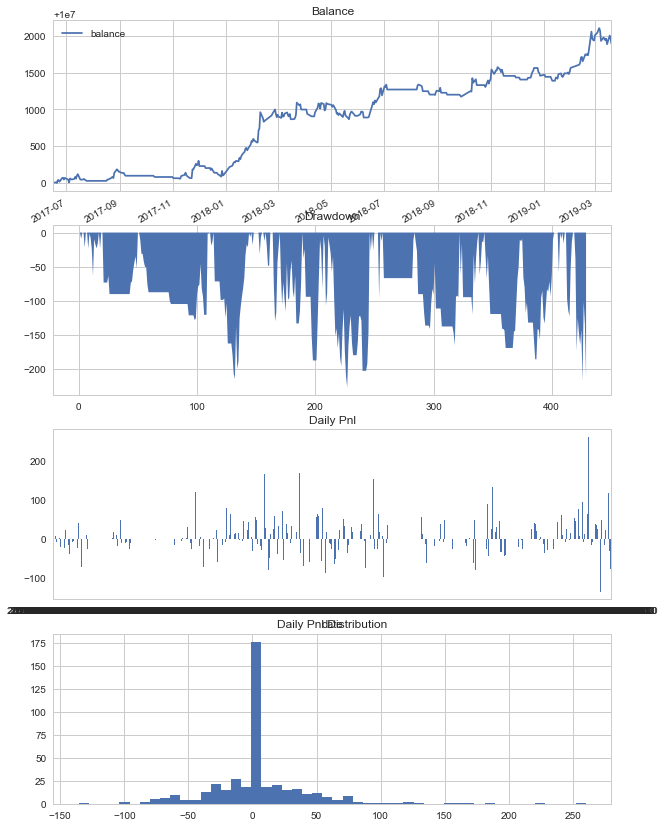

In [45]:
# 显示回测的每日绩效
engine.showDailyResult()

In [46]:
### 画图分析
chartLog = pd.DataFrame(engine.strategy.chartLog).set_index('datetime')
mp = htmlplot.getMultiPlot(engine, freq="5m")
mp.set_line(line=chartLog[['upperBand', 'lowerBand']], colors={"upperBand": "lightgray", 'lowerBand':'lightgray'}, pos=0)
mp.set_line(line=chartLog[['cmiMa']], colors={"cmiMa": "red"}, pos=1)
mp.show()

4. 优化策略参数
    1. 单线程运行优化
    2. 多线程优化

In [36]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
engine.setLog(False)
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
# setting.addParameter('cmiMaPeriod', 15, 31, 5)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('cmiThreshold', 40, 60, 4)    # 增加第二个优化参数，起始60，结束30，步进10
setting.addParameter('symbolList', ['IF88:CTP']) 

In [23]:
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(championStrategy, setting)

print('耗时：%s' %(time.time()-start))

2019-04-29 18:27:12.451014	------------------------------
2019-04-29 18:27:12.451014	setting: {'cmiThreshold': 40, 'symbolList': ['IF88:CTP']}
初始仓位: {'IF88:CTP_LONG': 0, 'IF88:CTP_SHORT': 0}
2019-04-29 18:27:12.454010	开始回测
2019-04-29 18:27:12.454010	策略初始化
2019-04-29 18:27:12.454010	准备载入数据：时间段:[20170616 10:00:00 , 20170616 11:00:00), 模式: bar
2019-04-29 18:27:12.475987	IF88:CTP： 从本地缓存文件实取60, 最大应取60, 还需从数据库取0
2019-04-29 18:27:12.477985	载入完成, 数据量:60
2019-04-29 18:27:12.477985	初始化预加载数据成功, 数据长度:60
2019-04-29 18:27:12.477985	策略初始化完成
2019-04-29 18:27:12.477985	策略启动完成
2019-04-29 18:27:12.477985	回测时间范围:[20170616 11:00:00,20190320 23:00:00)
2019-04-29 18:27:12.478984	当前回放的时间段:[20170616 11:00:00,20190320 23:00:00)
2019-04-29 18:27:16.725948	准备载入数据：时间段:[20170616 11:00:00 , 20190320 23:00:00), 模式: bar
2019-04-29 18:27:27.137529	IF88:CTP： 从本地缓存文件实取103110, 最大应取925200, 还需从数据库取822090
2019-04-29 18:27:34.028252	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-29 18:27:34.071210	载入完成, 数据量:103110
2019-04-29 18:27:34.159118

2019-04-29 18:29:22.444193	初始化预加载数据成功, 数据长度:60
2019-04-29 18:29:22.444193	策略初始化完成
2019-04-29 18:29:22.444193	策略启动完成
2019-04-29 18:29:22.444193	回测时间范围:[20170616 11:00:00,20190320 23:00:00)
2019-04-29 18:29:22.444193	当前回放的时间段:[20170616 11:00:00,20190320 23:00:00)
2019-04-29 18:29:26.139121	准备载入数据：时间段:[20170616 11:00:00 , 20190320 23:00:00), 模式: bar
2019-04-29 18:29:35.831193	IF88:CTP： 从本地缓存文件实取103110, 最大应取925200, 还需从数据库取822090
2019-04-29 18:29:42.688562	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-29 18:29:42.723527	载入完成, 数据量:103110
2019-04-29 18:29:42.808307	准备载入数据：时间段:[20170615 07:51:00 , 20170618 11:01:00), 模式: bar
2019-04-29 18:29:42.852261	IF88:CTP： 从本地缓存文件实取480, 最大应取4510, 还需从数据库取4030
2019-04-29 18:29:43.150956	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-29 18:29:43.151955	载入完成, 数据量:480
2019-04-29 18:29:43.188917	准备载入数据：时间段:[20170610 19:15:00 , 20170615 07:50:00), 模式: bar
2019-04-29 18:29:43.268836	IF88:CTP： 从本地缓存文件实取720, 最大应取6515, 还需从数据库取5795
2019-04-29 18:29:43.582281	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-29 18

In [24]:
print(pd.DataFrame(resultList).sort_values(1,  ascending=False))

                                                  0         1  \
0  {'cmiThreshold': 48, 'symbolList': ['IF88:CTP']}  1.705438   
1  {'cmiThreshold': 44, 'symbolList': ['IF88:CTP']}  1.618139   
2  {'cmiThreshold': 60, 'symbolList': ['IF88:CTP']}  1.383542   
3  {'cmiThreshold': 52, 'symbolList': ['IF88:CTP']}  1.238852   
4  {'cmiThreshold': 40, 'symbolList': ['IF88:CTP']}  1.055138   
5  {'cmiThreshold': 56, 'symbolList': ['IF88:CTP']}  0.886870   

                                                   2  
0  {'startDate': '2017-06-16', 'endDate': '2019-0...  
1  {'startDate': '2017-06-16', 'endDate': '2019-0...  
2  {'startDate': '2017-06-16', 'endDate': '2019-0...  
3  {'startDate': '2017-06-16', 'endDate': '2019-0...  
4  {'startDate': '2017-06-16', 'endDate': '2019-0...  
5  {'startDate': '2017-06-16', 'endDate': '2019-0...  


In [25]:
resultList

[({'cmiThreshold': 48, 'symbolList': ['IF88:CTP']},
  1.7054379335282404,
  {'annualizedReturn': 0.010675572279070943,
   'dailyCommission': 0.6513797674418608,
   'dailyNetPnl': 4.448155116279068,
   'dailyReturn': 4.4481551162790676e-05,
   'dailySlippage': 0.17906976744186046,
   'dailyTradeCount': 0.3581395348837209,
   'dailyTurnover': 1302.7595348837215,
   'endBalance': 10001912.7067,
   'endDate': '2019-03-20',
   'lossDays': 126,
   'maxDdPercent': -0.0022710039759594567,
   'maxDrawdown': -227.12559999898076,
   'profitDays': 137,
   'returnStd': 0.0004040635041125259,
   'sharpeRatio': 1.7054379335282404,
   'startDate': '2017-06-16',
   'totalCommission': 280.0933000000001,
   'totalDays': 430,
   'totalNetPnl': 1912.7066999999993,
   'totalReturn': 0.019127067000002107,
   'totalSlippage': 77.0,
   'totalTradeCount': 154,
   'totalTurnover': 560186.6000000002}),
 ({'cmiThreshold': 44, 'symbolList': ['IF88:CTP']},
  1.6181390737809533,
  {'annualizedReturn': 0.0102944528372

In [11]:
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)